In [23]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
%matplotlib inline

import sys
sys.path.append('../..')
from sf_lib.sf import (
    getFilename, 
    getMetadataValue, 
    parseTime, 
    getGroupSize, 
    extractTaskValue
)
from sf_lib.df import make_df_task0
from sf_lib.helpers import json_parser

In [24]:
# reload sf import while I'm working on extracting functionality to it from notebooks
from importlib import reload
import sf_lib
reload(sf_lib), reload(sf_lib.sf), reload(sf_lib.df)

(<module 'sf_lib' from '../..\\sf_lib\\__init__.py'>,
 <module 'sf_lib.sf' from '../..\\sf_lib\\sf.py'>,
 <module 'sf_lib.df' from '../..\\sf_lib\\df.py'>)

## `Hardcore` SpaceFluff category

### Load DataFrame, parse columns:

- load the csv into a dataframe,
- parse stringified columns,
- add Filename field
- filter by date (exclude classifications made in beta stage)
- drop unused columns `gold_standard` and `expert`
- maybe filter by latest workflow version

In [25]:
converters = {
    'subject_data': json_parser,
    'annotations': json_parser,
    'metadata': json_parser 
}

In [26]:
# load classifications
df = pd.read_csv('../../SpaceFluff/zooniverse_exports/classify-hardcore-edition-classifications.csv', converters=converters, delimiter=",")

# add Filename column at index 0
df.insert(0, 'Filename', df['subject_data'].apply(getFilename))
    
# filter by classification date (remove entries from before ~ October 20, 2020 as that's presumably the end of beta)
df['created_at'] = parseTime(df['created_at'])
end_of_beta = pd.Timestamp(date(2020,10,20), tz='utc')
df = df[df['created_at'] > end_of_beta]
    
# as far as I can tell, 'gold_standard' and 'expert' are never not NaN, so just remove them for readibility
df.drop(['gold_standard', 'expert'], axis=1, inplace=True)

# keep only classifications made on latest workflow version. @note: this might not be necessary
# workflow_versions = df['workflow_version'].unique()
# df = df[df['workflow_version'] == workflow_versions[-1]]

# create temporary df to extract isRetired and alreadySeen
df_temp = pd.DataFrame(columns=df.columns)

# drop rows where already_seen or retired. This way, we don't count two classifications for the same object from the same user,
#   extract retired and already_seen columns in this temporary dataframe
for field in ['retired', 'already_seen']:
    df_temp[field] = df['metadata'].apply(lambda x: getMetadataValue(x, field))
    
df = df[~df_temp['retired'] & ~df_temp['already_seen']]    
del df_temp

In [27]:
df.keys()

Index(['Filename', 'classification_id', 'user_name', 'user_id', 'user_ip',
       'workflow_id', 'workflow_name', 'workflow_version', 'created_at',
       'metadata', 'annotations', 'subject_data', 'subject_ids'],
      dtype='object')

### Inspect distribution of vote count:

In [28]:
group_by_name = df.groupby(['Filename'])

In [29]:
# check number of unique objects:
print('number of unique filenames:', df['Filename'].unique().shape[0])  # or group_by_name.groups.keys()

number of unique filenames: 6362


In [30]:
object_names = list(group_by_name.groups.keys())

In [31]:
votes_per_object = []
for name in object_names:
    count = getGroupSize(group_by_name.get_group(name))
    votes_per_object.append({
        'name': name,
        'votes': count
    })

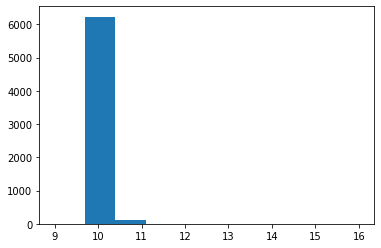

In [32]:
vote_counts = [entry['votes'] for entry in votes_per_object]
plt.hist(vote_counts)
plt.show()

In [33]:
sum(vote_counts), df.shape[0]

(63790, 63790)

## Extract actual votes:

- note that the tasks active in the `hardcore` workflow are T0, T2, T1, T3, T4, T5 and T9

#### Task descriptions:
- T0: 'Look at the very center of the image: do you see a single galaxy or a group of far away objects?'
- T2: 'Is the galaxy fluffy or is it bright?'
- T1: 'What color is the galaxy?'
- T3: 'Does the galaxy have a visible core?'
- T4: 'What shape is the galaxy?'
- T5: 'How would you describe the texture of the galaxy?'
- T9: 'Our bad! what do you see instead?'


- T0 is always asked. 
    - If user answers 'galaxy', then T2 through T5 are asked (in order listed above)
    - If user answers 'something else/empty center', they're asked T9.

In [34]:
task_indices = [0,2,1,3,4,5,9]
tasks = ['T{}'.format(i) for i in task_indices]

In [35]:
for task in tasks:
    df[task] = df['annotations'].apply(lambda x: extractTaskValue(x, task))

In [36]:
groupby_t0 = df.groupby(['T0'])
groupby_t0_groups = list(groupby_t0.groups.keys())